In [ ]:
from gfactor.main.gfactorsolar import SolarSpectrum
from gfactor.querying.LISIRDQuerying import LISIRDRetriever

import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
import seaborn as sns

import os
from astropy.convolution import convolve, Gaussian1DKernel
from astropy import units as u
from astropy.units import Quantity

: 

### <span style="color:rgb(192, 127, 15);"> Directory </span>

In [3]:
os.chdir("/home/blight25/projects/gfactor")
os.getcwd()

'/home/blight25/projects/gfactor'

### <span style="color:rgb(192, 127, 15);"> Plot Style </span>

In [4]:
sns.set_theme(style="darkgrid", palette="muted")

# <span style="color:rgb(18, 107, 170);"> **<u>Data Loading</u>** </span>

## <span style="color: #12AA83;">SUMER</span>

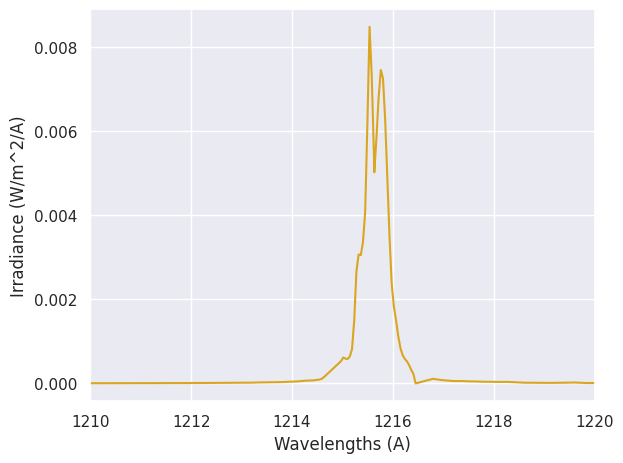

In [5]:
sumer = SolarSpectrum.sumer_spectrum(sumer_file="./spectra/SUMER/SUMER.txt")
fig, ax = plt.subplots()
ax.plot(sumer.spectral_axis, sumer.flux, color="goldenrod")
ax.set_xlabel("Wavelengths (A)")
ax.set_ylabel("Irradiance (W/m^2/A)")
ax.set_xlim(1210, 1220)
fig.tight_layout()
plt.show()

## <span style="color: #12AA83;">NNL</span>

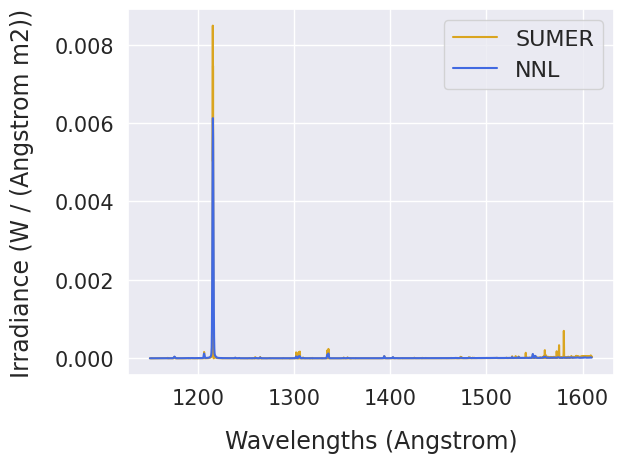

In [6]:
date="2014-04-15"
nnl = SolarSpectrum.daily_spectrum(date=date, dataset="NNL",
                                   res="high",
                                   daily_dir="./spectra")

# Trim values
sumer, nnl = SolarSpectrum.spectral_overlap(spec1=sumer, spec2=nnl)

fig, ax = plt.subplots()
ax.plot(sumer.spectral_axis, sumer.flux, color="goldenrod", label="SUMER")
ax.plot(nnl.spectral_axis, nnl.flux, color="royalblue", label="NNL")
ax.set_xlabel(f"Wavelengths ({nnl.spectral_axis.unit})", fontsize=17, labelpad=15)
ax.set_ylabel(f"Irradiance ({nnl.flux.unit})", fontsize=17, labelpad=15)

# Set tick parameters with larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(fontsize=16)
fig.tight_layout()
plt.show()

# <span style="color:rgb(18, 107, 170);"> **<u>Hyperparameters</u>** </span>

## <span style="color: #12AA83;">**Gaussian STD**</span>

### <span style="color:rgb(192, 127, 15);"> Choose Basis Feature </span>

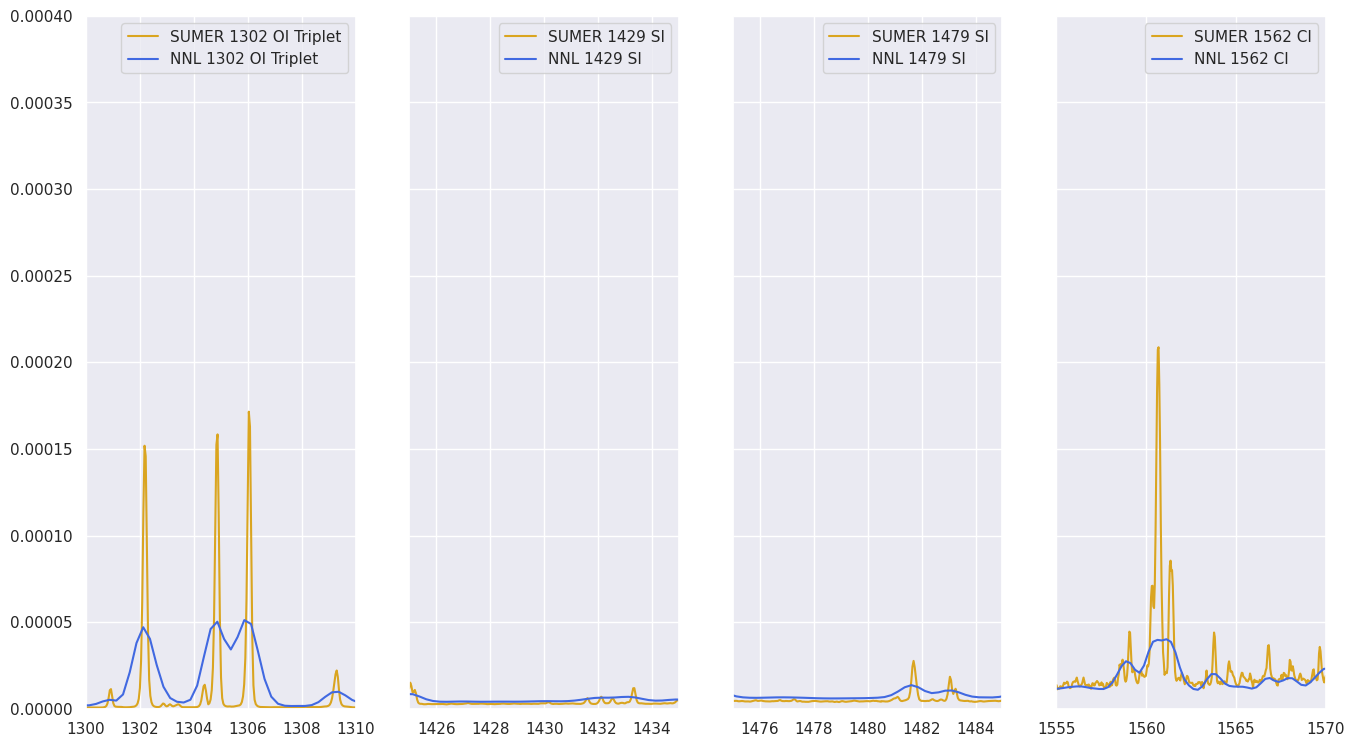

In [7]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 9), sharey=True)
features = {"1302 OI Triplet": [1300, 1310], 
            "1429 SI": [1425, 1435], 
            "1479 SI": [1475, 1485], 
            "1562 CI": [1555, 1570]}

for i, key in enumerate(list(features.keys())):
    axs[i].plot(sumer.spectral_axis, sumer.flux, label = "SUMER " + key, color = "goldenrod")
    axs[i].plot(nnl.spectral_axis, nnl.flux, label = "NNL " + key, color="royalblue")
    axs[i].set_xlim(features[key])
    axs[i].set_ylim(0, .0004)
    axs[i].legend()

plt.show()

Best peak to fit looks like the first peak in the OI 1302 Triplet

### <span style="color:rgb(192, 127, 15);"> Initial Parameter Guesstimates </span>

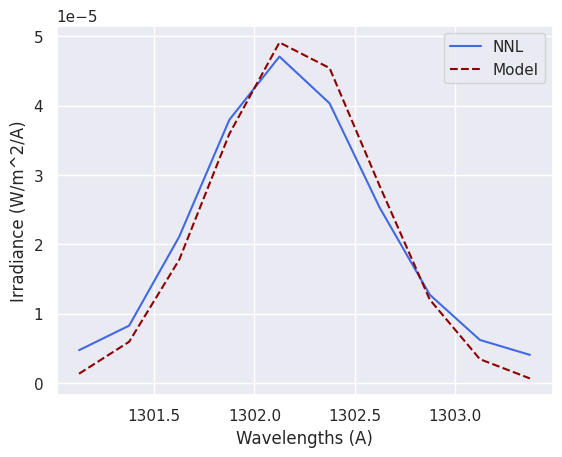

In [8]:
nnl_indices = np.array(list(range(len(nnl.spectral_axis))))
nnl_OI_indices = nnl_indices[(nnl.spectral_axis.value >= 1301) & (nnl.spectral_axis.value <= 1303.5)]
height = 5e-5
mean = 1302.2
pixel_std = .4
model = height*np.exp(-.5*np.square((nnl.spectral_axis[nnl_OI_indices].value - mean) / pixel_std))
plt.plot(nnl.spectral_axis[nnl_OI_indices], nnl.flux[nnl_OI_indices], label="NNL", color="royalblue")
plt.plot(nnl.spectral_axis[nnl_OI_indices], model, color="darkred", label="Model", linestyle="--")
plt.legend()
plt.xlabel("Wavelengths (A)")
plt.ylabel("Irradiance (W/m^2/A)")
plt.plot()
plt.show()

### <span style="color:rgb(192, 127, 15);"> Fit Results </span>

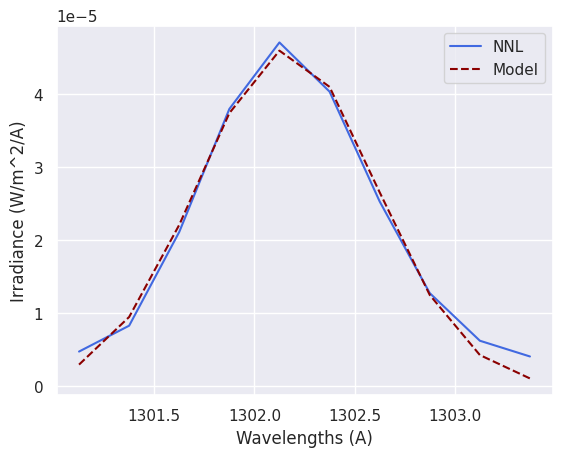

In [9]:
height, mean, std, pixel_std  = nnl.feature_fit(height=height, mean=mean, std=pixel_std,
                                           feature = [1301, 1303.5])

model_flux = height.value*np.exp(-.5*np.square((nnl.spectral_axis[nnl_OI_indices].value - mean.value) / std.value))
plt.plot(nnl.spectral_axis[nnl_OI_indices], nnl.flux[nnl_OI_indices], label="NNL", color="royalblue")
plt.plot(nnl.spectral_axis[nnl_OI_indices], model_flux, color="darkred", label="Model", linestyle="--")
plt.legend()
plt.xlabel("Wavelengths (A)")
plt.ylabel("Irradiance (W/m^2/A)")
plt.plot()
plt.show()

### <span style="color:rgb(192, 127, 15);"> Visualize Kernel </span>

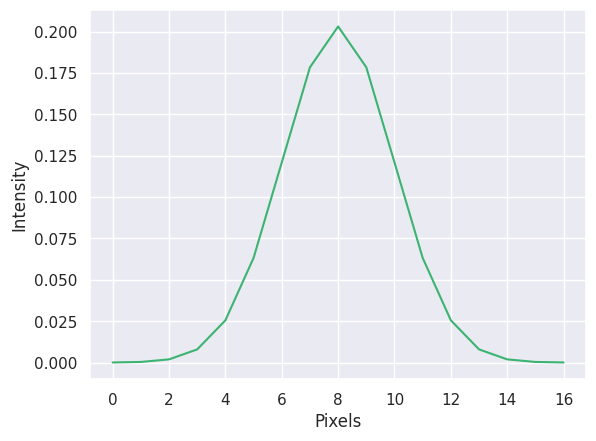

In [10]:
kernel = Gaussian1DKernel(pixel_std)
plt.plot(kernel, color="mediumseagreen")
plt.xlabel("Pixels")
plt.ylabel("Intensity")
plt.show()

### <span style="color:rgb(192, 127, 15);"> Convolution Results: Lyman-Alpha </span>

In [11]:
nnl_kernel = Gaussian1DKernel(stddev = pixel_std)
sumer_downsampled = SolarSpectrum.resample(spec=sumer, new_axis=nnl.spectral_axis)
dc_sumer = SolarSpectrum.convolution(spec=sumer_downsampled, std=pixel_std)

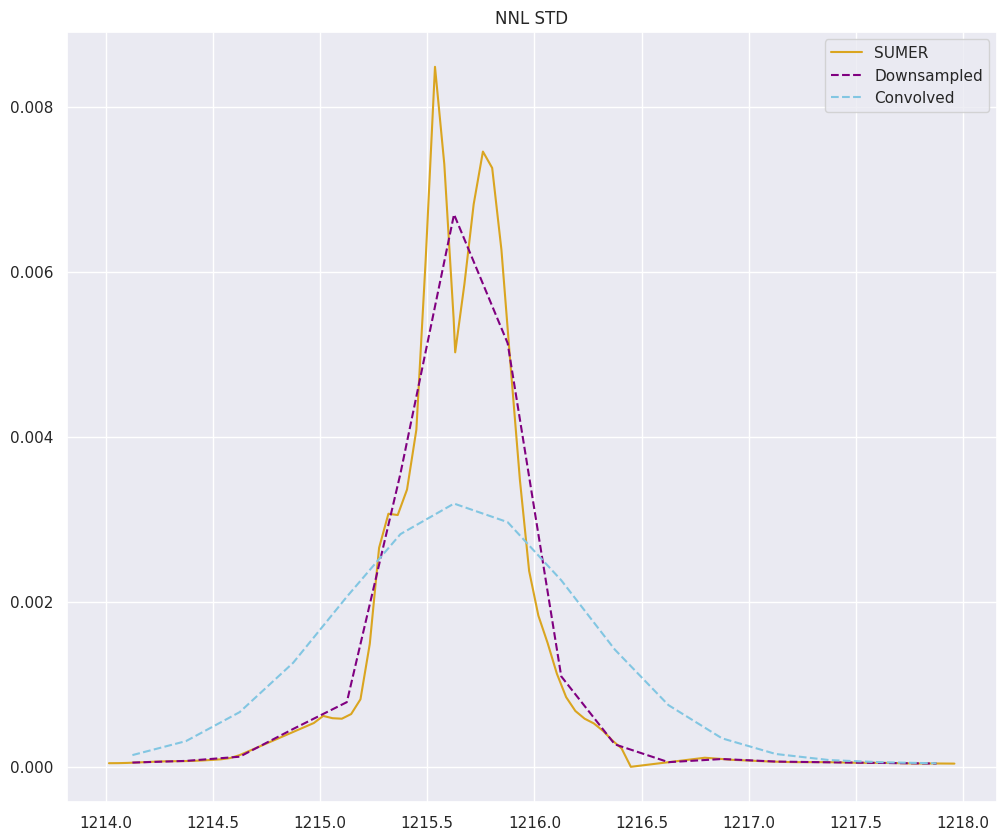

In [12]:
# Define a formatter function to round to 1 decimal place
def format_func(value, tick_number):
    return f"{value:.1f}"

formatter = FuncFormatter(format_func)

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(sumer.spectral_axis[(sumer.spectral_axis.value > 1214) & (sumer.spectral_axis.value < 1218)], 
         sumer.flux[(sumer.spectral_axis.value > 1214) & (sumer.spectral_axis.value < 1218)],
         label="SUMER", 
         color="goldenrod", 
         )
ax.plot(nnl.spectral_axis[(nnl.spectral_axis.value > 1214) & (nnl.spectral_axis.value < 1218)],
         sumer_downsampled.flux[(nnl.spectral_axis.value > 1214) & (nnl.spectral_axis.value < 1218)],
         label="Downsampled", 
         color="purple", 
         linestyle="--")
ax.plot(nnl.spectral_axis[(nnl.spectral_axis.value > 1214) & (nnl.spectral_axis.value < 1218)],
         dc_sumer.flux[(nnl.spectral_axis.value > 1214) & (nnl.spectral_axis.value < 1218)],
         label="Convolved",
         color="c", 
         linestyle="--")

ax.xaxis.set_major_formatter(formatter)
ax.set_title("NNL STD")
ax.legend()

plt.show()

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Procedure</u>** </span>

In [13]:
output, downsampled_output, dc_output, fit_results = SolarSpectrum.daily_fit(poly_degree=5,
                                                                             sumer=sumer,
                                                                             daily_spec=nnl,
                                                                             gaussian_std=pixel_std,
                                                                             fit="polynomial")
fit_results

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Results</u>** </span>

### <span style="color:rgb(192, 127, 15);"> Emissions </span>

In [14]:
emissions = {"Lyman-alpha": [1210, 1220], "1302 OI Triplet": [1300, 1310], 
            "1562 CI": [1559, 1563]}

## <span style="color: #12AA83;">**Lyman-Alpha**</span>

### <span style="color:rgb(192, 127, 15);"> Integrated Fluxes, Resolutions, Errors </span>

In [15]:
sumer.emissions = emissions
nnl.emissions = emissions
output.emissions = emissions
downsampled_output.emissions = emissions
dc_output.emissions = emissions
sumer_downsampled.emissions = emissions
dc_sumer.emissions = emissions

# NNL Resolutions
nnl_min_res = (nnl.spectral_axis[-1] - nnl.spectral_axis[0]) / len(nnl.spectral_axis)
nnl_lyman_res = nnl.emissions['Lyman-alpha']['Resolution']

# SUMER Resolutions
sumer_res = (sumer.spectral_axis[-1] - sumer.spectral_axis[0]) / len(sumer.spectral_axis)
sumer_lyman_res = sumer.emissions['Lyman-alpha']['Resolution']

# Errors
sumer_integration_error = math.fabs((dc_sumer.emissions["Lyman-alpha"]["Integrated Flux"] - \
                                     sumer.emissions["Lyman-alpha"]["Integrated Flux"]) / sumer.emissions["Lyman-alpha"]["Integrated Flux"]) * 100
output_integration_error = math.fabs((dc_output.emissions["Lyman-alpha"]["Integrated Flux"] - \
                                      output.emissions["Lyman-alpha"]["Integrated Flux"]) / output.emissions["Lyman-alpha"]["Integrated Flux"]) * 100
output_vs_nnl_integration_error = math.fabs((output.emissions["Lyman-alpha"]["Integrated Flux"] - \
                                             nnl.emissions["Lyman-alpha"]["Integrated Flux"]) / nnl.emissions["Lyman-alpha"]["Integrated Flux"]) * 100
output_dc_vs_nnl_integration_error = math.fabs((dc_output.emissions["Lyman-alpha"]["Integrated Flux"] - \
                                                nnl.emissions["Lyman-alpha"]["Integrated Flux"]) / nnl.emissions["Lyman-alpha"]["Integrated Flux"]) * 100


### <span style="color:rgb(192, 127, 15);"> Results </span>

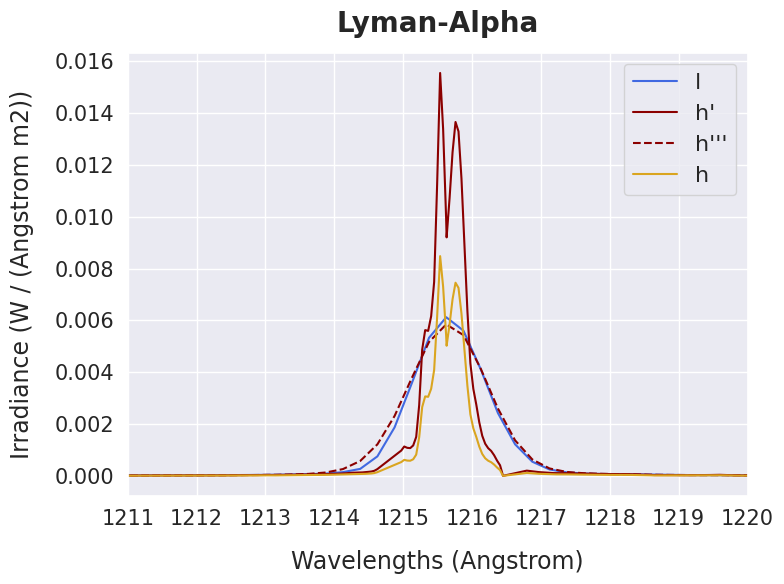

Spectral Resolutions:

NNL Resolution Over Whole Spectrum: 0.24986 Angstrom
NNL Resolution Over Lyman Alpha: 0.24375 Angstrom

SUMER Resolution Over Whole Spectrum: 0.04274 Angstrom
SUMER Resolution Over Lyman Alpha: 0.04573 Angstrom

----------------------

Lyman-Alpha Integrated Flux at Solar Minimum:

NNL: 0.00812 W / m2
Output: 0.00931 W / m2
DC Output: 0.00846 W / m2
SUMER: 0.00508 W / m2
DC SUMER: 0.00462 W / m2

----------------------

Integration Errors:

Output vs. DC Output: 9.10% 
SUMER vs. DC SUMER: 9.10% 
Output vs NNL: 14.71% 
DC Output vs NNL: 4.27% 


In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(nnl.spectral_axis, nnl.flux, label = "l", color="royalblue")
ax.plot(output.spectral_axis, output.flux, label="h'", color="darkred", )
plt.plot(dc_output.spectral_axis, dc_output.flux, label="h'''", color="darkred", linestyle="--", )
ax.plot(sumer.spectral_axis, sumer.flux, label="h", color="goldenrod")
#plt.plot(dc_sumer.spectral_axis, dc_sumer.flux, label="DC SUMER", color="goldenrod", linestyle="--")
ax.set_xlabel(f"Wavelengths ({nnl.spectral_axis.unit})", fontsize=17, labelpad=15)
ax.set_ylabel(f"Irradiance ({nnl.flux.unit})", fontsize=17, labelpad=15)
ax.set_xlim(1211, 1220)

# Set tick parameters with larger font size
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title("Lyman-Alpha", fontsize=20, fontweight="bold", pad=15)
ax.legend(fontsize=16)
fig.tight_layout()
plt.show()

# Display
print("Spectral Resolutions:\n")
print(f"NNL Resolution Over Whole Spectrum: {nnl_min_res:.5f}")
print(f"NNL Resolution Over Lyman Alpha: {nnl_lyman_res:.5f}\n")

print(f"SUMER Resolution Over Whole Spectrum: {sumer_res:.5f}")
print(f"SUMER Resolution Over Lyman Alpha: {sumer_lyman_res:.5f}")
print("\n----------------------")

print("\nLyman-Alpha Integrated Flux at Solar Minimum:\n")
print(f"NNL: {nnl.emissions['Lyman-alpha']['Integrated Flux']:.5f}")
print(f"Output: {output.emissions['Lyman-alpha']['Integrated Flux']:.5f}")
print(f"DC Output: {dc_output.emissions['Lyman-alpha']['Integrated Flux']:.5f}")
print(f"SUMER: {sumer.emissions['Lyman-alpha']['Integrated Flux']:.5f}")
print(f"DC SUMER: {dc_sumer.emissions['Lyman-alpha']['Integrated Flux']:.5f}")
print("\n----------------------")

print("\nIntegration Errors:\n")
print(f"Output vs. DC Output: {output_integration_error:.2f}% ")
print(f"SUMER vs. DC SUMER: {sumer_integration_error:.2f}% ")
print(f"Output vs NNL: {output_vs_nnl_integration_error:.2f}% ")
print(f"DC Output vs NNL: {output_dc_vs_nnl_integration_error:.2f}% ")

## <span style="color: #12AA83;">**Other Features**</span>

### <span style="color:rgb(192, 127, 15);"> Results </span>

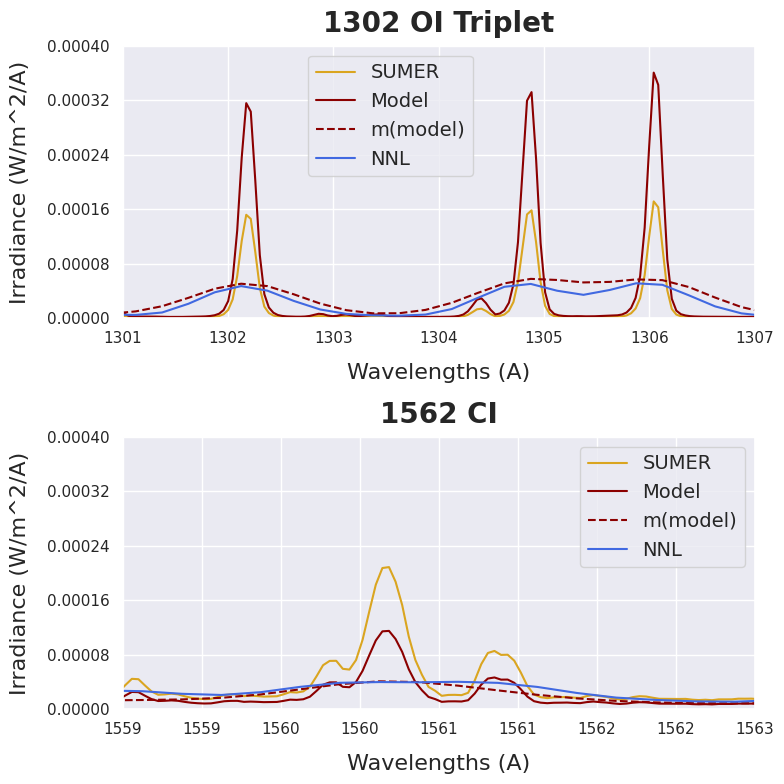

In [17]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8), sharey=True)

features = {"1302 OI Triplet": [1301, 1307], 
            "1562 CI": [1559, 1563]}

def integer_formatter(x, pos):
    return f'{int(x)}'

for i, key in enumerate(list(features.keys())):
    axs[i].plot(sumer.spectral_axis, sumer.flux, label = "SUMER", color = "goldenrod")
    axs[i].plot(output.spectral_axis, output.flux, color="darkred", label= "Model")
    axs[i].plot(dc_output.spectral_axis, dc_output.flux, color="darkred", label="m(model)", linestyle="--")
    axs[i].plot(nnl.spectral_axis, nnl.flux, label = "NNL", color = "royalblue")
    axs[i].set_xlim(features[key])
    axs[i].set_ylim(0, .0004)
    axs[i].set_xlabel("Wavelengths (A)", fontsize=16, labelpad=12)
    axs[i].set_ylabel("Irradiance (W/m^2/A)", fontsize=16, labelpad=12)
    #axs[i].ticklabel_format(axis='y', style='sci', scilimits=(4,4))
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set the number of y-ticks
    axs[i].xaxis.set_major_formatter(FuncFormatter(integer_formatter))  # Remove decimals from x-ticks   
    axs[i].set_title(key, fontsize=20, fontweight="bold", pad=10)

axs[0].legend(loc='upper right', bbox_to_anchor=(.57, 1), fontsize=14)
axs[1].legend(fontsize=14)

fig.tight_layout()
plt.show()

# <span style="color:rgb(18, 107, 170);"> **<u>GOES Validation</u>** </span>

## <span style="color: #12AA83;">**Preprocessing**</span>

### <span style="color:rgb(192, 127, 15);"> GOES Data </span>

Note that GOES can't be filtered by wavelength, since it's not a spectrum

In [18]:
retriever = LISIRDRetriever()
raw_GOES_data = retriever.retrieve(dataset="GOES_18", date=date)
raw_GOES_data

ValueError: Chosen date is out of bounds: must fall between 2022-09-09 and 2025-01-27

In [ ]:
raw_GOES_data = raw_GOES_data.loc[:, ~raw_GOES_data.columns.str.contains('flag')]
raw_GOES_data.columns

Index(['irr_256 (W/m^2)', 'irr_284 (W/m^2)', 'irr_304 (W/m^2)',
       'irr_1175 (W/m^2)', 'irr_1216 (W/m^2)', 'irr_1335 (W/m^2)',
       'irr_1405 (W/m^2)', 'irr_284_1nm (W/m^2)', 'irr_304_1nm (W/m^2)',
       'irr_1216_1nm (W/m^2)', 'au_factor (dimensionless)', 'irr_256_1au',
       'irr_284_1au', 'irr_304_1au', 'irr_1175_1au', 'irr_1216_1au',
       'irr_1335_1au', 'irr_1405_1au', 'irr_284_1nm_1au', 'irr_304_1nm_1au',
       'irr_1216_1nm_1au', 'date (YYYY-MM-DD)', 'Dataset'],
      dtype='object')

Drop all columns except standard integrated irradiance for SUMER-overlapping wavelengths

In [ ]:
GOES_wavelengths = [1175, 1216, 1335, 1405]
GOES_wave_bounds = [(1169.1, 1181.7), (1208.95, 1221.6), (1328.4, 1341), (1389.65, 1406.4)]
GOES_data = [raw_GOES_data[f"irr_{wavelength} (W/m^2)"].values[0] for wavelength in GOES_wavelengths]
GOES = pd.DataFrame({'GOES': GOES_data}, index=GOES_wavelengths)

GOES

,GOES
1175,0.000099
1216,0.008220
1335,0.000235
1405,0.000152


## <span style="color: #12AA83;">**Evaluation**</span>

### <span style="color:rgb(192, 127, 15);"> Reference Data </span>

In [ ]:
high_res_integrated = [output.integrated_flux(wavelengths).value for wavelengths in GOES_wave_bounds]
low_res_integrated = [dc_output.integrated_flux(wavelengths).value for wavelengths in GOES_wave_bounds]
nnl_integrated = [nnl.integrated_flux(wavelengths).value for wavelengths in GOES_wave_bounds]

spectra = pd.DataFrame({'Output (high-res)': high_res_integrated, 'Output (low-res)': low_res_integrated, 'NNL': nnl_integrated}, index=GOES_wavelengths)
spectra_str = spectra.map(lambda x: f"{x:.2e}")

spectra_str

,Output (high-res),Output (low-res),NNL
1175,8.04e-05,8.15e-05,9.64e-05
1216,9.03e-03,8.35e-03,8.01e-03
1335,2.44e-04,2.39e-04,2.25e-04
1405,1.44e-04,1.42e-04,1.44e-04


### <span style="color:rgb(192, 127, 15);"> Relative Error </span>

In [ ]:
error_data = [np.abs(spectra.loc[wavelength].values - GOES.loc[wavelength].values[0])/GOES.loc[wavelength].values[0] * 100 for wavelength in GOES_wavelengths]
error_data = np.stack(error_data, axis=0)

errors = pd.DataFrame({'Output (high-res)': error_data[:, 0], 'Output (low-res)': error_data[:, 1], 'NNL': error_data[:, 2]}, index=GOES_wavelengths)
errors_str = errors.map(lambda x: f"{x:.2f}%")

errors_str

,Output (high-res),Output (low-res),NNL
1175,18.53%,17.38%,2.31%
1216,9.88%,1.61%,2.58%
1335,3.97%,1.65%,4.04%
1405,4.96%,6.26%,5.25%


### <span style="color:rgb(192, 127, 15);"> Relative Disparity </span>

In [ ]:
diffs_data = [spectra.loc[wavelength].values - GOES.loc[wavelength].values[0] for wavelength in GOES_wavelengths]
diffs_data = np.stack(diffs_data, axis=0)

diffs = pd.DataFrame({'Output (high-res)': diffs_data[:, 0], 'Output (low-res)': diffs_data[:, 1], 'NNL': diffs_data[:, 2]}, index=GOES_wavelengths)
diffs_str = diffs.map(lambda x: f"{x:.2e}")

diffs_str

,Output (high-res),Output (low-res),NNL
1175,-1.83e-05,-1.72e-05,-2.28e-06
1216,8.12e-04,1.32e-04,-2.12e-04
1335,9.32e-06,3.89e-06,-9.50e-06
1405,-7.53e-06,-9.51e-06,-7.97e-06
